# Topics covered in this notebook

- Camera calibration
- Distortion correction
- Color/gradient threshold
- Perspective transform

Then we will apply these techniques to

- Detect lane lines
- Determine the lane curvature

In [1]:
from __future__ import print_function, division
import numpy as np
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

## Distortion check with chessboard

There are two types of distortions

* Radial Distortion (most common)
  * distorts the edges of images
  * makes lines or objects appear more or less curved
  * measured in $(k1, k2, k3)$
  * ![radial distortion](assets/radial_distortion.png)
* Tangential Distortion
  * when a camera's lens is not perfectly aligned
  * it makes the image look tilted
  * measured in $(p1, p2)$
  * ![image.png](assets/tangential_distortion.png)

## 1. ChessBoard Corners

* First step to deal with the image distortion is to calibrate a camera using the chessboard corners
* What are corners?
    * Corners are points where two black squares and two white squares interesect
    * In OpenCV,
        * `cv2.findChessboardCorners(image, (nx, ny), None) -> ret, corners`
        * `cv2.drawChessboardCorners(image, (nx, ny), corners, ret) -> image`

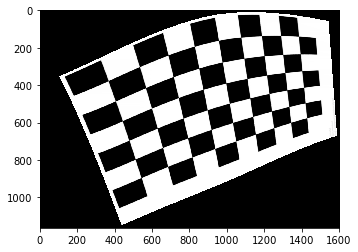

In [2]:
image = cv2.imread("assets/chessboard_distorted.png")
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image);

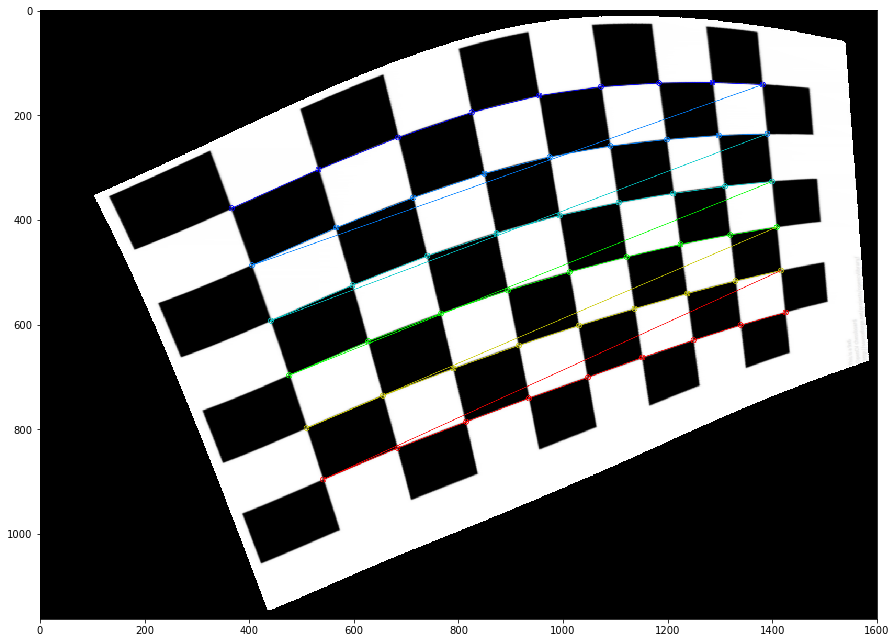

In [3]:
# 0. count nx, ny = (9, 6)
# 1. grayscale
# 2. find corners
# 3. draw corners
image = cv2.imread("assets/chessboard_distorted.png")
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

nx = 9
ny = 6

gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)

if ret:
    result = cv2.drawChessboardCorners(image, (nx, ny), corners, ret)
    plt.figure(figsize=(15, 15));
    plt.imshow(image);

## 2. Calibrate Camera

This step is basically
* Run the above step multiple times and collect corners location
* Calibrate the camera
    * In OpenCV,
        * `ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(obj_pt_list, img_pt_list, img_size, None, None)`
            * `obj_pt_list` are true coordinates, (x, y, z) for corners
                * i.e `[(0, 0, 0), (1, 0, 0), (2, 0, 0), ... (8, 5, 0)]`
            * `img_pt_list` are actual coordinates, (x, y, z) for corners found in the actual images
                * i.e they are dirty numbers that need to be calibrated

In [4]:
import glob

In [5]:
# define object points: (x, y, z) coordinates for each corners
# there are 6 rows and 5 columns and z is 0 because it's 2-d
# e.g. (0, 0, 0), (1, 0, 0), (2, 0, 0), ..., (7, 5, 0)
obj_p = np.zeros([6 * 8, 3], np.float32)
obj_p[:, :2] = np.mgrid[0:8, 0:6].T.reshape(-1, 2)
obj_p

array([[ 0.,  0.,  0.],
       [ 1.,  0.,  0.],
       [ 2.,  0.,  0.],
       [ 3.,  0.,  0.],
       [ 4.,  0.,  0.],
       [ 5.,  0.,  0.],
       [ 6.,  0.,  0.],
       [ 7.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 1.,  1.,  0.],
       [ 2.,  1.,  0.],
       [ 3.,  1.,  0.],
       [ 4.,  1.,  0.],
       [ 5.,  1.,  0.],
       [ 6.,  1.,  0.],
       [ 7.,  1.,  0.],
       [ 0.,  2.,  0.],
       [ 1.,  2.,  0.],
       [ 2.,  2.,  0.],
       [ 3.,  2.,  0.],
       [ 4.,  2.,  0.],
       [ 5.,  2.,  0.],
       [ 6.,  2.,  0.],
       [ 7.,  2.,  0.],
       [ 0.,  3.,  0.],
       [ 1.,  3.,  0.],
       [ 2.,  3.,  0.],
       [ 3.,  3.,  0.],
       [ 4.,  3.,  0.],
       [ 5.,  3.,  0.],
       [ 6.,  3.,  0.],
       [ 7.,  3.,  0.],
       [ 0.,  4.,  0.],
       [ 1.,  4.,  0.],
       [ 2.,  4.,  0.],
       [ 3.,  4.,  0.],
       [ 4.,  4.,  0.],
       [ 5.,  4.,  0.],
       [ 6.,  4.,  0.],
       [ 7.,  4.,  0.],
       [ 0.,  5.,  0.],
       [ 1.,  5.

In [6]:
obj_pt_list = []
img_pt_list = []

images = glob.glob("assets/calibration_wide/GO*.jpg")

for idx, fname in enumerate(images):
    
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    ret, corners = cv2.findChessboardCorners(gray, (8, 6), None)
    
    if ret:
        obj_pt_list.append(obj_p)
        img_pt_list.append(corners)


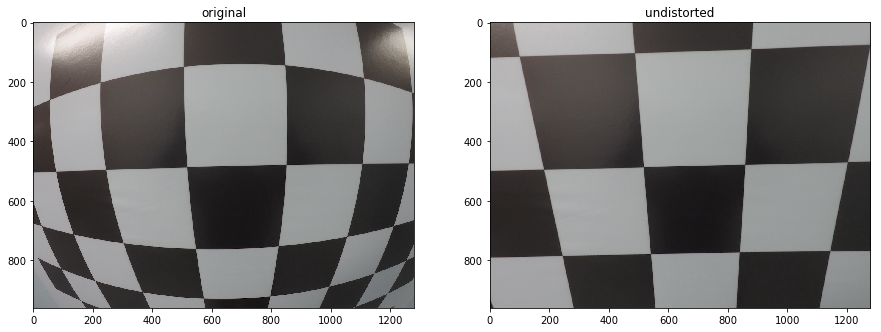

In [7]:
test_img = cv2.imread("assets/calibration_wide/test_image.jpg")
img_size = (test_img.shape[1], test_img.shape[0])

# Do camera calibration given object points and image points
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(obj_pt_list,
                                                   img_pt_list,
                                                   img_size, None, None)

dst = cv2.undistort(test_img, mtx, dist, None, mtx)
cv2.imwrite('assets/calibration_wide/test_undist.jpg', dst)


plt.figure(figsize=(15, 15))
plt.subplot(1, 2, 1);
plt.imshow(test_img);
plt.title("original");

plt.subplot(1, 2, 2);
plt.imshow(dst);
plt.title("undistorted");

## 3. Transform Perspective

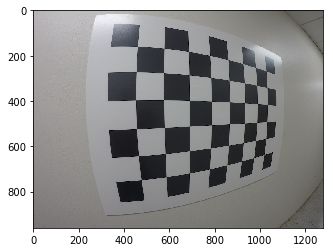

In [8]:
# we will transform this image to the bird's eye view
image = cv2.imread("assets/calibration_wide/GOPR0032.jpg")
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image);

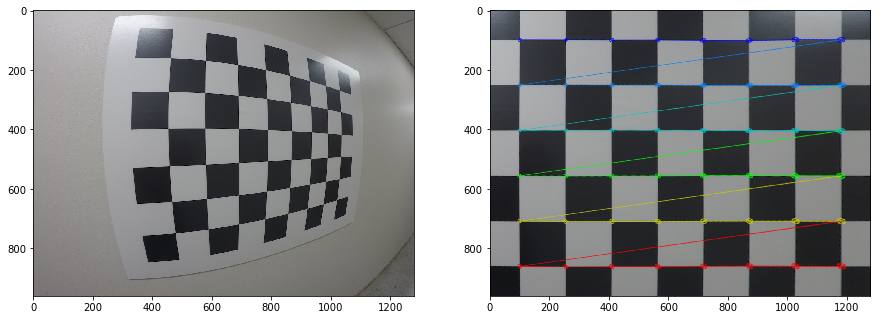

In [9]:
image = cv2.imread("assets/calibration_wide/GOPR0032.jpg")
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

nx, ny = 8, 6

def undistort_warp(image, mtx, dist, nx, ny):
    """ Undistort and transform to the bird eye view
    
    Parameters
    ----------
    image : 3d-array (H, W, C)
    
    mtx : 2d-array (3, 3)
        Calibrate Camera Matrix
        
    dist: 2d-array (1, 5)
        Calibrate camera coefficient matrix
        [k1, k2, p1, p2, k3]
    
    """
    undist = cv2.undistort(image, mtx, dist)
    gray = cv2.cvtColor(undist, cv2.COLOR_RGB2GRAY)
    ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)

    if ret:
        _ = cv2.drawChessboardCorners(undist, (nx, ny), corners, ret)

        src = np.array([corners[0], corners[nx - 1], corners[-1], corners[-nx]], dtype=np.float32)

        offset = 100
        height, width = gray.shape

        dst = [[offset, offset],
               [width - offset, offset],
               [width - offset, height - offset],
               [offset, height - offset]]
        dst = np.array(dst, dtype=np.float32)

        M = cv2.getPerspectiveTransform(src, dst)    
        warped = cv2.warpPerspective(undist, M, (width, height))
    
    return warped, M

warped, M = undistort_warp(image, mtx, dist, nx, ny)

plt.figure(figsize=(15, 15))
plt.subplot(1, 2, 1);
plt.imshow(image);

plt.subplot(1, 2, 2);
plt.imshow(warped);

## 4. Apply sobel

The $sobel_x$, $sobel_y$ with a kernel size of 3 look like this respectively
![sobel_operator](assets/sobel-operator.png)

- Larger Kernel size $\rightarrow$ smoother gradient
- Taking the gradient in the $x$ direction emphasizes the edges close to the vertical line 

In [10]:
# Define a function that applies Sobel x or y, 
# then takes an absolute value and applies a threshold.
# Note: calling your function with orient='x', thresh_min=5, thresh_max=100
# should produce output like the example image shown above this quiz.
def abs_sobel_thresh(img, orient='x', thresh_min=0, thresh_max=255):
    
    # Apply the following steps to img
    # 1) Convert to grayscale
    # 2) Take the derivative in x or y given orient = 'x' or 'y'
    # 3) Take the absolute value of the derivative or gradient
    # 4) Scale to 8-bit (0 - 255) then convert to type = np.uint8
    # 5) Create a mask of 1's where the scaled gradient magnitude 
            # is > thresh_min and < thresh_max
    # 6) Return this mask as your binary_output image
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    
    if orient == 'x':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 1, 0)    
    else:
        sobel = cv2.Sobel(gray, cv2.CV_64F, 0, 1)
    
    abs_sobel = np.abs(sobel)
    eight_bits_sobel = np.uint8(abs_sobel * 255 / np.max(abs_sobel))
    
    binary_output = np.zeros_like(eight_bits_sobel)
    binary_output[(thresh_min <= eight_bits_sobel) & (eight_bits_sobel <= thresh_max)] = 1
    
    return binary_output

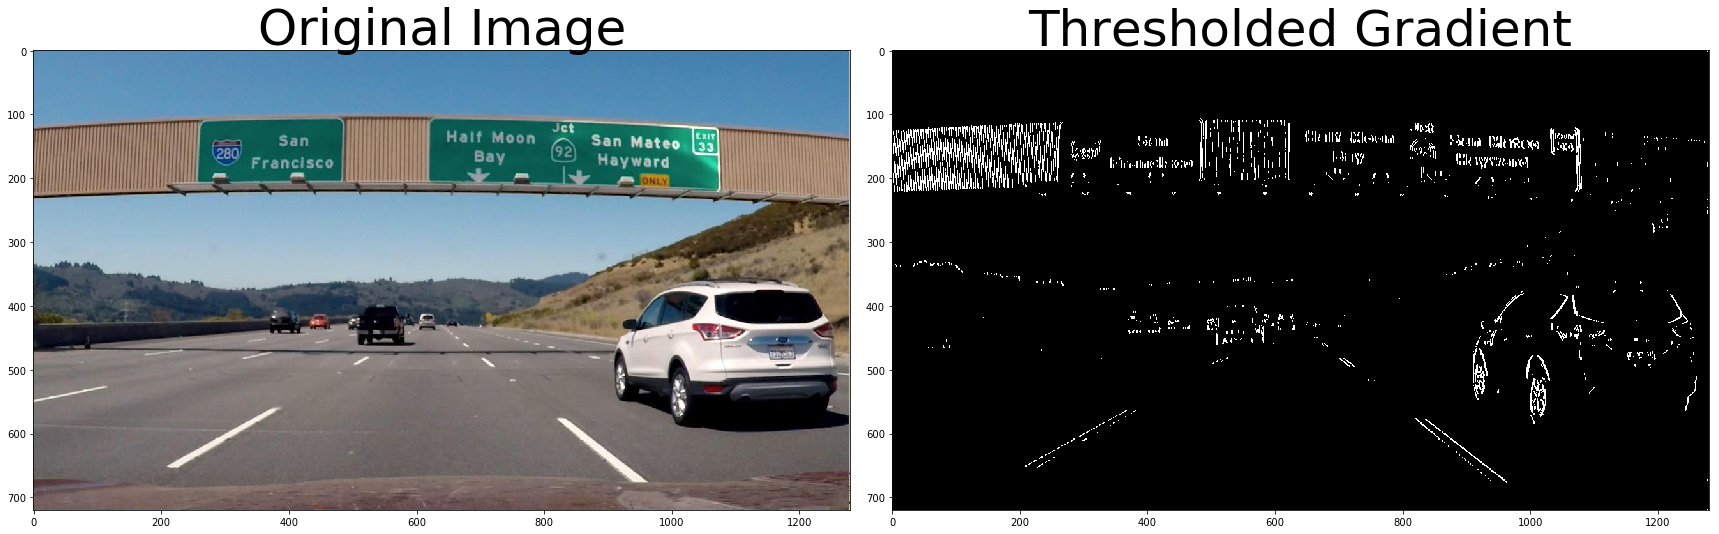

In [11]:
image = cv2.imread("assets/signs_vehicles_xygrad.jpg")
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Run the function
grad_binary = abs_sobel_thresh(image, orient='x', thresh_min=50, thresh_max=255)
# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout();

ax1.imshow(image);
ax1.set_title('Original Image', fontsize=50);

ax2.imshow(grad_binary, cmap='gray');
ax2.set_title('Thresholded Gradient', fontsize=50);

## 5. Use Sobel x and y together

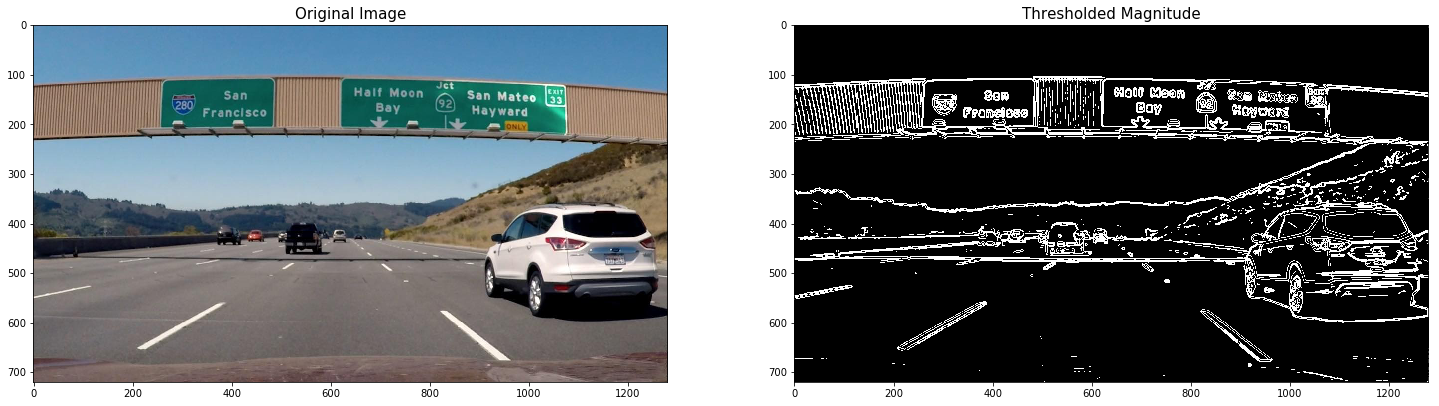

In [12]:
image = cv2.imread("assets/signs_vehicles_xygrad.jpg")
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)


def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    """Compute binary output based on sobel

    Parameters
    ----------
    img : np.array, (H, W, C)

    sobel_kernel : int
        Kernel Size for Sobel

    mag_thresh : tuple (min, max)
        Magnitude Threshold values

    Returns
    ----------
    binary_output : (H, W)
        Binarized Image
    """

    # Apply the following steps to img
    # 1) Convert to grayscale
    # 2) Take the gradient in x and y separately
    # 3) Calculate the magnitude
    # 4) Scale to 8-bit (0 - 255) and convert to type = np.uint8
    # 5) Create a binary mask where mag thresholds are met
    # 6) Return this mask as your binary_output image
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    sobel_x = cv2.Sobel(gray, cv2.CV_64F, 1, 0, None, sobel_kernel)
    sobel_y = cv2.Sobel(gray, cv2.CV_64F, 0, 1, None, sobel_kernel)

    magnitude = np.sqrt(sobel_x ** 2 + sobel_y ** 2)
    magnitude = np.uint8(magnitude * 255 / np.max(magnitude))

    mask = (mag_thresh[0] <= magnitude) & (magnitude <= mag_thresh[1])

    binary_output = np.zeros_like(gray)
    binary_output[mask] = 1

    return binary_output


# Run the function
mag_binary = mag_thresh(image, sobel_kernel=9, mag_thresh=(30, 100))
# Plot the result
plt.figure(figsize=(25, 10))

plt.subplot(1, 2, 1)
plt.imshow(image)
plt.title('Original Image', fontsize=15)

plt.subplot(1, 2, 2)
plt.imshow(mag_binary, cmap='gray')
plt.title('Thresholded Magnitude', fontsize=15);

## 6. Direction of the Gradient

In the case of lane lines, we are interested in edges of particular directions.

The direction of the gradient is simply the inverse tangent (arctan) of the y-gradient divided by the x-gradient

$$ orientation = \arctan\left( \frac{sobel_y}{sobel_x} \right) $$

- $ orientation = 0 $ implies a horizontal line
- $ orientation = \frac{\pi}{2} $ implies a vertical line

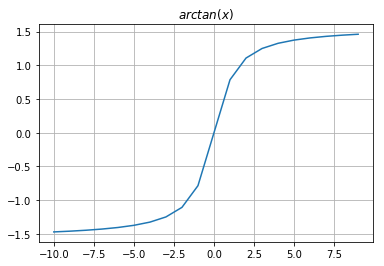

In [13]:
# arctan looks like this
x = np.arange(-10, 10)
plt.plot(x, np.arctan(x))
plt.grid('on')
plt.title("$arctan(x)$")

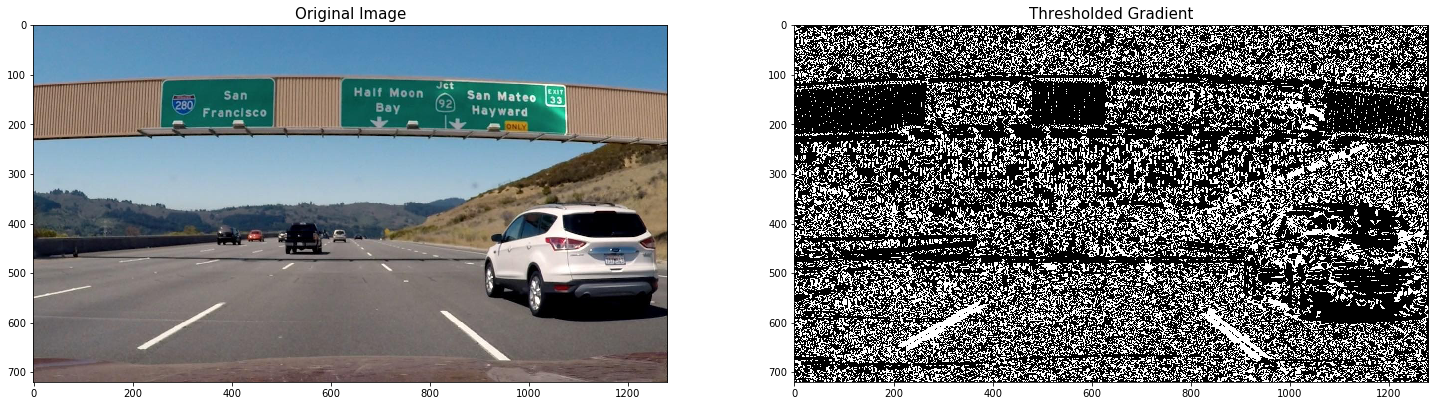

In [14]:
image = cv2.imread("assets/signs_vehicles_xygrad.jpg")
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)


def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi / 2)):
    """Compute the orientation using Sobel
    """
    # Apply the following steps to img
    # 1) Convert to grayscale
    # 2) Take the gradient in x and y separately
    # 3) Take the absolute value of the x and y gradients
    # 4) Use np.arctan2(abs_sobely, abs_sobelx) to calculate the direction of the gradient
    # 5) Create a binary mask where direction thresholds are met
    # 6) Return this mask as your binary_output image

    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

    sobel_x = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobel_y = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)

    sobel_x = np.abs(sobel_x)
    sobel_y = np.abs(sobel_y)

    direction = np.arctan2(sobel_y, sobel_x)

    mask = (direction >= thresh[0]) & (direction <= thresh[1])

    binary_output = np.zeros_like(gray)
    binary_output[mask] = 1

    return binary_output



# Run the function
dir_binary = dir_threshold(image, sobel_kernel=15, thresh=(0.7, 1.3))

# Plot the result
plt.figure(figsize=(25, 10))

plt.subplot(1, 2, 1)
plt.imshow(image)
plt.title('Original Image', fontsize=15)

plt.subplot(1, 2, 2)
plt.imshow(dir_binary, cmap='gray')
plt.title('Thresholded Gradient', fontsize=15)

## 7. Combining thresholds

Let's see if I can remember all the methods

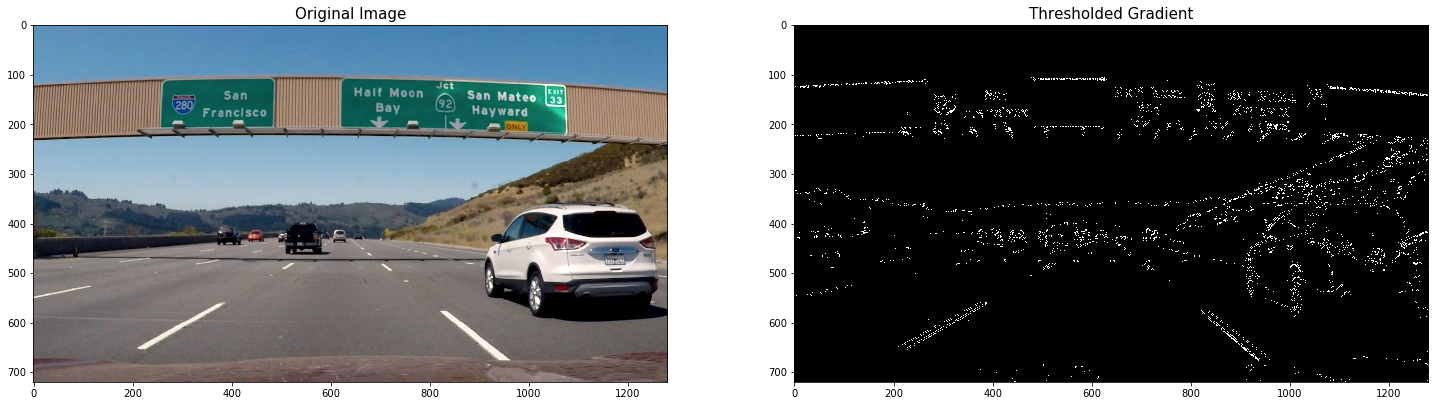

In [15]:
def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0, 255)):
    # Calculate directional gradient
    # Apply threshold
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    if orient == 'x':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    else:
        sobel = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
        
    sobel = np.abs(sobel)
    
    mask = (thresh[0] <= sobel) & (sobel <= thresh[1])
    
    grad_binary = np.zeros_like(gray)
    grad_binary[mask] = 1    
    
    return grad_binary

def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    # Calculate gradient magnitude
    # Apply threshold
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    sobel_x = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobel_y = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    
    magnitude = np.sqrt(sobel_x**2 + sobel_y**2)
    
    mask = (mag_thresh[0] <= magnitude) & (magnitude <= mag_thresh[1])
    
    mag_binary = np.zeros_like(gray)
    mag_binary[mask] = 1
    
    return mag_binary

def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Calculate gradient direction
    # Apply threshold
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    sobel_x = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobel_y = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    
    sobel_x = np.abs(sobel_x)
    sobel_y = np.abs(sobel_y)
    
    orient = np.arctan2(sobel_y, sobel_x)
    
    mask = (thresh[0] <= orient) & (orient <= thresh[1])
    
    dir_binary = np.zeros_like(gray)
    dir_binary[mask] = 1
    
    return dir_binary

image = cv2.imread("assets/signs_vehicles_xygrad.jpg")
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Choose a Sobel kernel size
ksize = 3 # Choose a larger odd number to smooth gradient measurements

# Apply each of the thresholding functions
gradx = abs_sobel_thresh(image, orient='x', sobel_kernel=ksize, thresh=(50, 150))
grady = abs_sobel_thresh(image, orient='y', sobel_kernel=ksize, thresh=(50, 150))
mag_binary = mag_thresh(image, sobel_kernel=ksize, mag_thresh=(100, 200))
dir_binary = dir_threshold(image, sobel_kernel=ksize, thresh=(0.7, 1.3))

combined = np.zeros_like(dir_binary)
combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1

# Plot the result
plt.figure(figsize=(25, 10))

plt.subplot(1, 2, 1)
plt.imshow(image)
plt.title('Original Image', fontsize=15)

plt.subplot(1, 2, 2)
plt.imshow(combined, cmap='gray')
plt.title('Thresholded Gradient', fontsize=15);

## 8. Color spaces

Before anything,

- `matplotlib.image.imread(...)` returns a RGB image
- `cv2.imread(...)` returns a BGR image

RGB, HSV, HLS spaces


<img src="https://d17h27t6h515a5.cloudfront.net/topher/2016/November/5834e496_screen-shot-2016-11-22-at-4.35.48-pm/screen-shot-2016-11-22-at-4.35.48-pm.png" style="max-width: 50%; float: left;" alt="RGB Space" />
<img src="https://d17h27t6h515a5.cloudfront.net/topher/2016/November/5834e6ed_screen-shot-2016-11-22-at-4.44.32-pm/screen-shot-2016-11-22-at-4.44.32-pm.png" style="max-width: 50%; float: left;" alt="HSV/HLR Space"/>

In OpenCV, the range of H is between 0 and 179 (typically its' 0-359 because it's the degree, but it's scaled half for the range can be represented in 8-bit)

Algorithms from RGB to HLS

- Constant
    $$ V_\max = \max(R, G, B) $$
    $$ V_\min = \min(R, G, B) $$
- Get H
    $$ H = \frac{30 (G - B)}{V_\max - V_\min} \tag{if $V_\max = R$}$$
    
    $$ H = 60 + \frac{30 (B - R)}{V_\max - V_\min} \tag{if $V_\max = G$}$$
    
    $$ H = 120 + \frac{30 (R - G)}{V_\max - V_\min} \tag{if $V_\max = B$}$$
- Get L
    $$ L = \frac{V_\max + V_\min}{2} $$
- Get S
    $$ S = \frac{V_\max - V_\min}{V_\max + V_\min} \tag{if $ L < 0.5 $} $$
    
    $$ S = \frac{V_\max - V_\min}{2 - (V_\max + V_\min)} \tag{if $ L \geq 0.5 $} $$

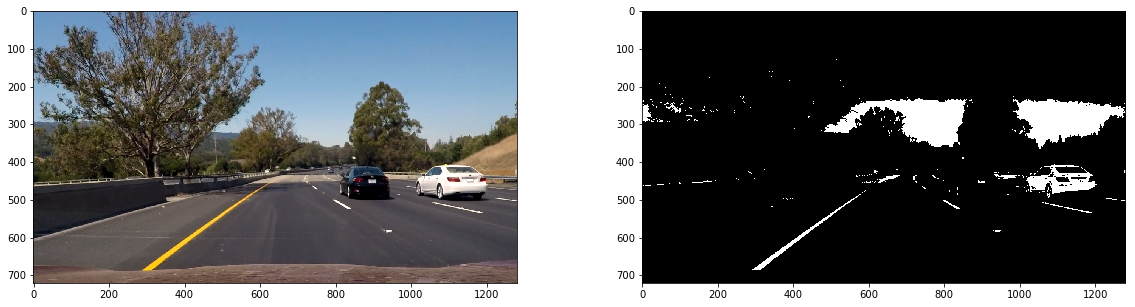

In [16]:
image = plt.imread("assets/test6.jpg")
gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
binary = np.zeros_like(gray)
thresh = (180, 255)
binary[(gray > thresh[0]) & (gray < thresh[1])] = 1
plt.figure(figsize=(20, 5))
plt.subplot(1, 2, 1); plt.imshow(image);
plt.subplot(1, 2, 2); plt.imshow(binary, cmap="gray");

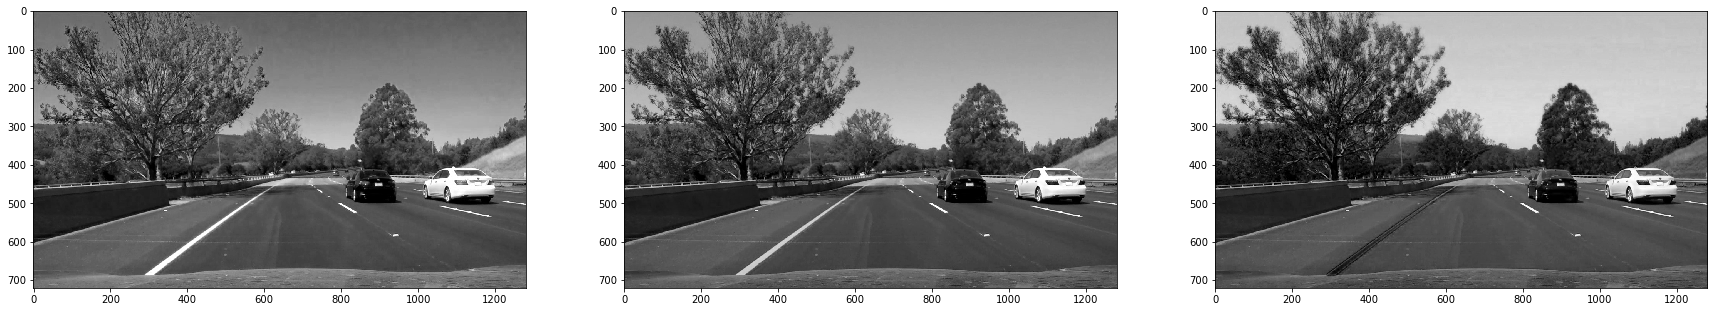

In [17]:
# Notice the yellow line is not visible on the B channel
R = image[..., 0]
G = image[..., 1]
B = image[..., 2]

plt.figure(figsize=(30, 10))
plt.subplot(1, 3, 1)
plt.imshow(R, cmap="gray")

plt.subplot(1, 3, 2)
plt.imshow(G, cmap="gray")

plt.subplot(1, 3, 3)
plt.imshow(B, cmap="gray");

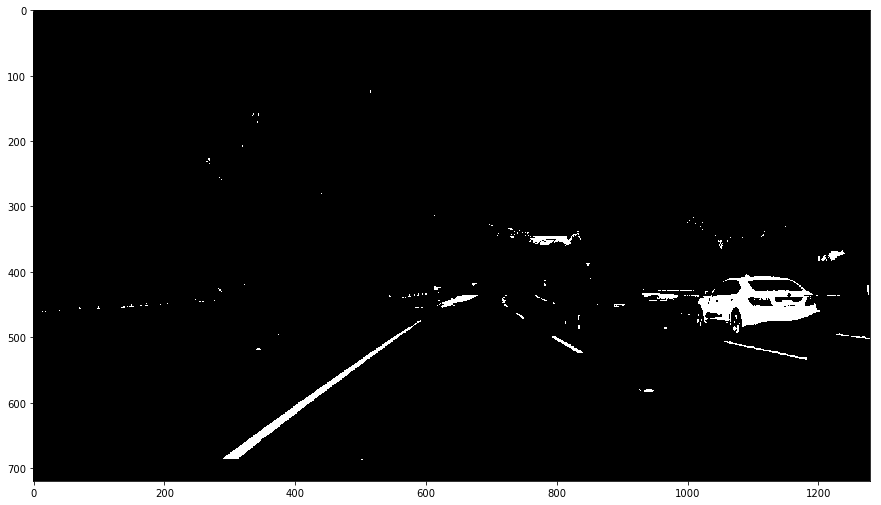

In [18]:
R_binary = np.zeros_like(R)
thresh = (200, 255)
R_binary[(thresh[0] <= R) & (R <= thresh[1])] = 1

plt.figure(figsize=(15, 10))
plt.imshow(R_binary, cmap="gray");

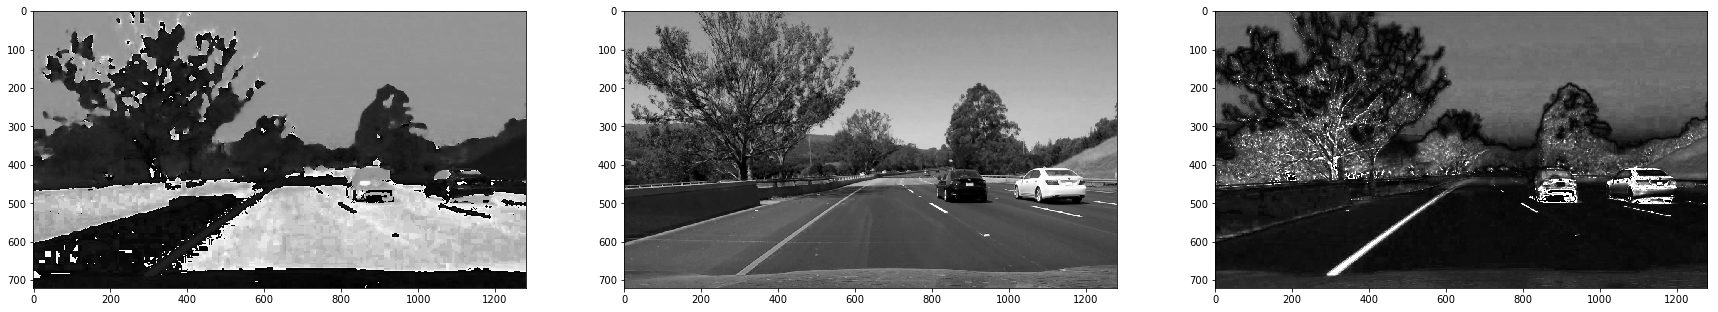

In [19]:
# Check in HLS
hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
H = hls[..., 0]
L = hls[..., 1]
S = hls[..., 2]

plt.figure(figsize=(30, 10))
plt.subplot(1, 3, 1)
plt.imshow(H, cmap="gray")

plt.subplot(1, 3, 2)
plt.imshow(L, cmap="gray")

plt.subplot(1, 3, 3)
plt.imshow(S, cmap="gray");

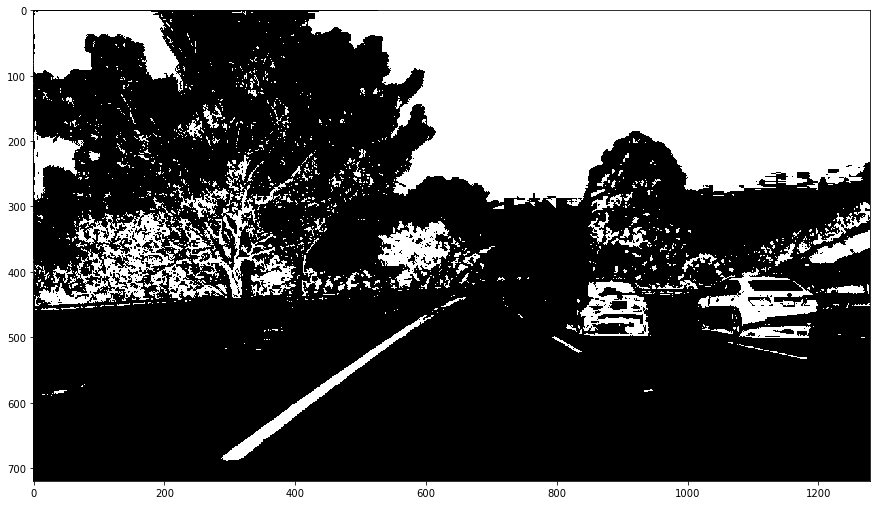

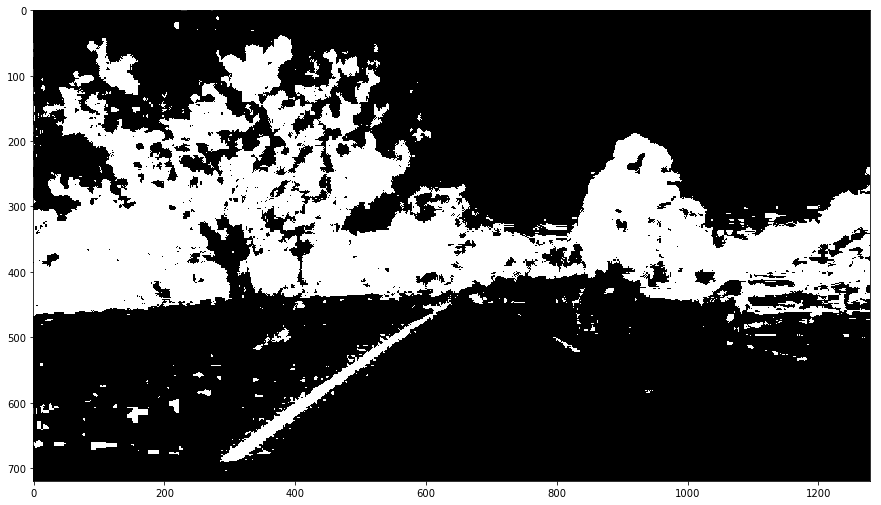

In [20]:
thresh = (90, 255)
binary = np.zeros_like(S)
binary[(S > thresh[0]) & (S <= thresh[1])] = 1

plt.figure(figsize=(15, 10))
plt.imshow(binary, cmap="gray")

thresh = (15, 100)
binary = np.zeros_like(H)
binary[(H > thresh[0]) & (H <= thresh[1])] = 1

plt.figure(figsize=(15, 10))
plt.imshow(binary, cmap="gray")

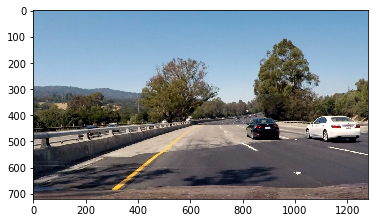

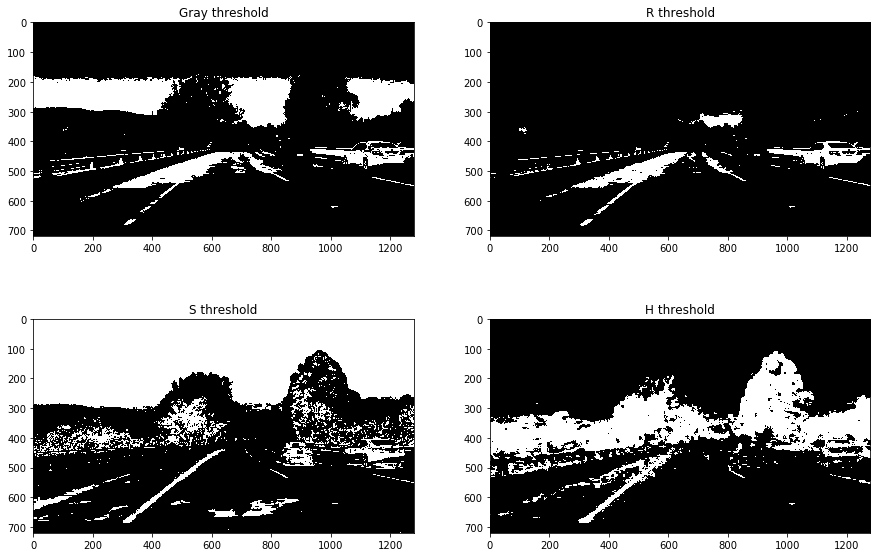

In [21]:
image = plt.imread("assets/test4.jpg")
gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
plt.imshow(image)
plt.show()

plt.figure(figsize=(15, 10))

# Gray threshold
binary = np.zeros_like(gray)
thresh = (180, 255)
binary[(gray > thresh[0]) & (gray < thresh[1])] = 1

plt.subplot(2, 2, 1)
plt.imshow(binary, cmap="gray")
plt.title("Gray threshold");

# R threshold
R = image[..., 0]

R_binary = np.zeros_like(R)
thresh = (200, 255)
R_binary[(thresh[0] <= R) & (R <= thresh[1])] = 1

plt.subplot(2, 2, 2)
plt.imshow(R_binary, cmap="gray");
plt.title("R threshold")



# S threshold
hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
H = hls[..., 0]
L = hls[..., 1]
S = hls[..., 2]

thresh = (90, 255)
binary = np.zeros_like(S)
binary[(S > thresh[0]) & (S <= thresh[1])] = 1

plt.subplot(2, 2, 3)
plt.imshow(binary, cmap="gray")
plt.title("S threshold")

# H threshold
thresh = (15, 100)
binary = np.zeros_like(H)
binary[(H > thresh[0]) & (H <= thresh[1])] = 1

plt.subplot(2, 2, 4)
plt.imshow(binary, cmap="gray")
plt.title("H threshold");

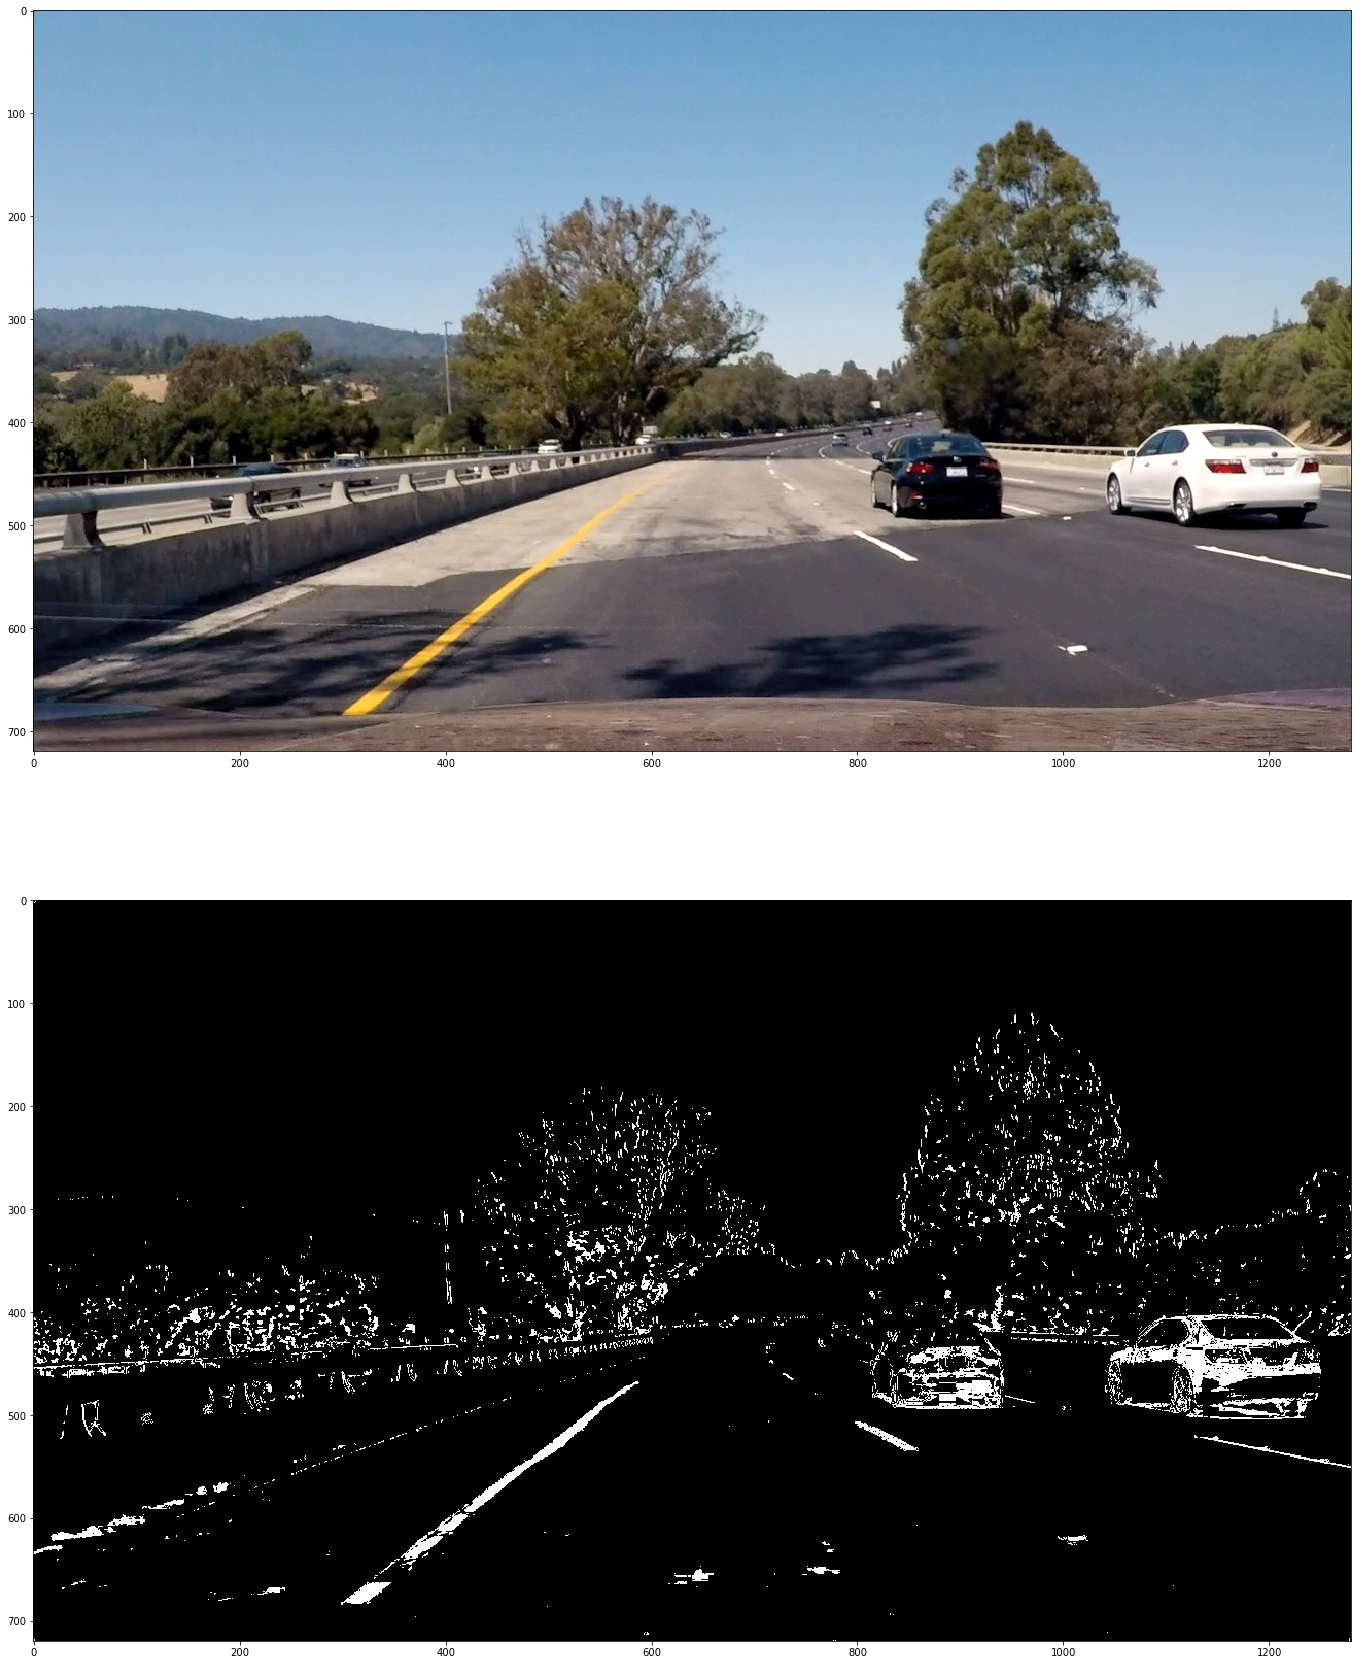

In [22]:
image = plt.imread("assets/test4.jpg")

def pipeline(img, s_thresh=(170, 255), sx_thresh=(50, 100)):
    img = np.copy(img)
    # Convert to HSV color space and separate the V channel
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
    l_channel = hsv[:, :, 1]
    s_channel = hsv[:, :, 2]
    
    # Sobel x
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0)  # Take the derivative in x
    # Absolute x derivative to accentuate lines away from horizontal
    abs_sobelx = np.absolute(sobelx)
    scaled_sobel = np.uint8(255 * abs_sobelx / np.max(abs_sobelx))

    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) &
             (scaled_sobel <= sx_thresh[1])] = 1

    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    # Stack each channel
    
    # Note color_binary[:, :, 0] is all 0s, effectively an all black image. It might
    # be beneficial to replace this channel with something else.
    color_binary = np.dstack((np.zeros_like(sxbinary), sxbinary, s_binary))
    
    color_binary = np.mean(color_binary, -1)
    color_binary = (color_binary - np.min(color_binary)) / (np.max(color_binary) - np.min(color_binary))
    
    binary = np.zeros_like(color_binary)
    binary[color_binary >= 0.5] = 1
    
    return binary
    


result = pipeline(image)

plt.figure(figsize=(50, 30))
plt.subplot(2, 1, 1)
plt.imshow(image)

plt.subplot(2, 1, 2)
plt.imshow(result, cmap="gray")

## 9. Perspective

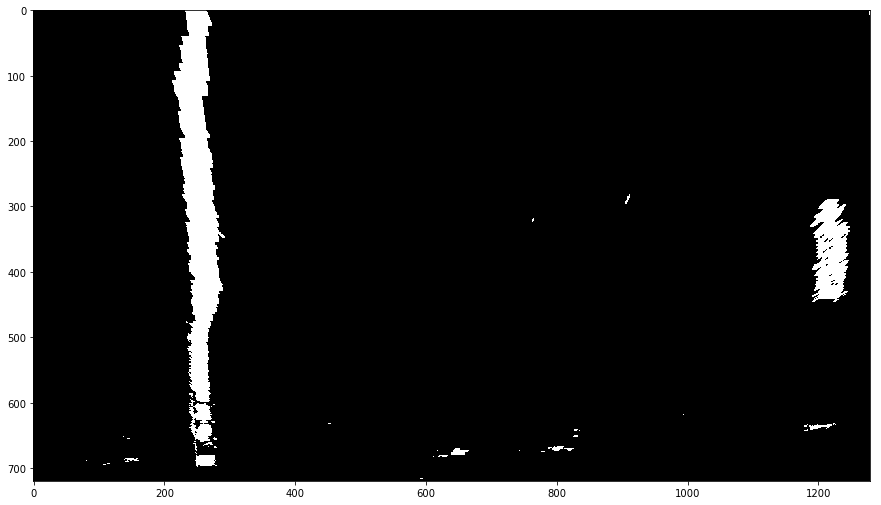

In [23]:
binary = np.copy(result).astype(np.uint8)

H, W = binary.shape
W_offset = 100
points = [[W_offset, H],  [W // 2, H // 2], [W - W_offset, H]]


def roi_crop(img, points):
    mask = np.zeros_like(img, dtype=np.uint8)

    # fill the ROI so it doesn't get wiped out when the mask is applied
    points = np.array([points], dtype=np.int32)

    # from Masterfool: use cv2.fillConvexPoly if you know it's convex
    cv2.fillPoly(mask, points, 255)

    assert img.shape == mask.shape, "{} {}".format(img.shape, mask.shape)
    return cv2.bitwise_and(img, mask)


def warp_perspective(img, src, dst):
    H, W = img.shape

    src = np.array(src, dtype=np.float32)
    dst = np.array(dst, dtype=np.float32)

    M = cv2.getPerspectiveTransform(src, dst)
    M_inv = cv2.getPerspectiveTransform(dst, src)

    return cv2.warpPerspective(img, M, (W, H)), M, M_inv


img = roi_crop(binary, points)

src = [[W_offset, H],
       [W // 2 - 100, H - H // 3],
       [W // 2 + 100, H - H // 3],
       [W - W_offset, H]]

dst = [[W_offset, H],
       [W_offset, 0],
       [W - W_offset, 0],
       [W - W_offset, H]]

img, M, M_inv = warp_perspective(img, src, dst)

plt.figure(figsize=(15, 10))
plt.imshow(img, cmap="gray")

## 10. Sliding windows search

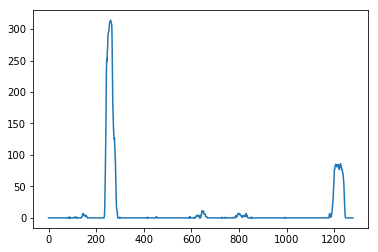

In [24]:
# lower half histogram to find it
H, W = img.shape
hist = np.sum(img[H // 2:, :], axis = 0)
plt.plot(hist)

(720, 0)

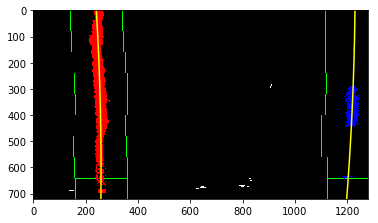

In [25]:
binary_warped = np.copy(img)
H, W = binary_warped.shape
histogram = np.sum(binary_warped[H // 2:, :], axis=0)

# Create an output image to draw on and  visualize the result
out_img = np.dstack((binary_warped, binary_warped, binary_warped)) * 255

# Find the peak of the left and right halves of the histogram
# These will be the starting point for the left and right lines
midpoint = np.int(W / 2)
leftx_base = np.argmax(histogram[:midpoint])
rightx_base = np.argmax(histogram[midpoint:]) + midpoint

# Choose the number of sliding windows
nwindows = 9

# Set height of windows
window_height = np.int(H / nwindows)

# Identify the x and y positions of all nonzero pixels in the image
nonzero = binary_warped.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])

# Current positions to be updated for each window
leftx_current = leftx_base
rightx_current = rightx_base

# Set the width of the windows +/- margin
margin = 100

# Set minimum number of pixels found to recenter window
minpix = 50

# Create empty lists to receive left and right lane pixel indices
left_lane_inds = []
right_lane_inds = []

# Step through the windows one by one
for window in range(nwindows):
    # Identify window boundaries in x and y (and right and left)
    win_y_low = H - (window + 1) * window_height
    win_y_high = H - window * window_height
    
    win_xleft_low = leftx_current - margin
    win_xleft_high = leftx_current + margin
    
    win_xright_low = rightx_current - margin
    win_xright_high = rightx_current + margin
    
    # Draw the windows on the visualization image
    cv2.rectangle(out_img, 
                  pt1=(win_xleft_low, win_y_low),
                  pt2=(win_xleft_high, win_y_high),
                  color=(0, 255, 0),
                  thickness=2)
    
    cv2.rectangle(out_img,
                  pt1=(win_xright_low, win_y_low),
                  pt2=(win_xright_high, win_y_high),
                  color=(0, 255, 0),
                  thickness=2)
    
    # Identify the nonzero pixels in x and y within the window
    good_left_inds = ((nonzeroy >= win_y_low)
                      & (nonzeroy < win_y_high)
                      & (nonzerox >= win_xleft_low)
                      & (nonzerox < win_xleft_high)).nonzero()[0]
    
    good_right_inds = ((nonzeroy >= win_y_low)
                       & (nonzeroy < win_y_high)
                       & (nonzerox >= win_xright_low)
                       & (nonzerox < win_xright_high)).nonzero()[0]
    
    # Append these indices to the lists
    left_lane_inds.append(good_left_inds)
    right_lane_inds.append(good_right_inds)
    
    # If you found > minpix pixels, recenter next window on their mean position
    if len(good_left_inds) > minpix:
        leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
    
    if len(good_right_inds) > minpix:
        rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

# Concatenate the arrays of indices
left_lane_inds = np.concatenate(left_lane_inds)
right_lane_inds = np.concatenate(right_lane_inds)

# Extract left and right line pixel positions
leftx = nonzerox[left_lane_inds]
lefty = nonzeroy[left_lane_inds]
rightx = nonzerox[right_lane_inds]
righty = nonzeroy[right_lane_inds]

# Fit a second order polynomial to each
left_fit = np.polyfit(lefty, leftx, 2)
right_fit = np.polyfit(righty, rightx, 2)


# Generate x and y values for plotting
ploty = np.linspace(0, H - 1, H)

def polynomial(x, params):
    """Returns a polynomial
    
    y = ax^2 + bx + c
    
    Parameters
    ----------
    x : 1d-array
    
    params : list
        [a, b, c]
    
    Returns
    ----------
    list : 1d-array
        Polynomial values
    """
    a, b, c = params
    return a * x**2 + b * x + c


left_fitx = polynomial(ploty, left_fit)
right_fitx = polynomial(ploty, right_fit)

out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
plt.imshow(out_img)

plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)

(720, 0)

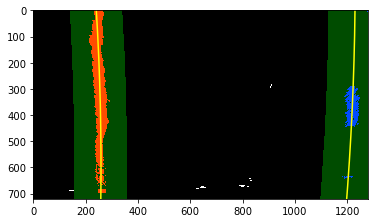

In [26]:
# Assume you now have a new warped binary image
# from the next frame of video (also called "binary_warped")
# It's now much easier to find line pixels!
nonzero = binary_warped.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])
margin = 100
left_lane_inds = ((nonzerox > (left_fit[0] * (nonzeroy**2) + left_fit[1] * nonzeroy + left_fit[2] - margin))
                  & (nonzerox < (left_fit[0] * (nonzeroy**2) + left_fit[1] * nonzeroy + left_fit[2] + margin)))
right_lane_inds = ((nonzerox > (right_fit[0] * (nonzeroy**2) + right_fit[1] * nonzeroy + right_fit[2] - margin))
                   & (nonzerox < (right_fit[0] * (nonzeroy**2) + right_fit[1] * nonzeroy + right_fit[2] + margin)))

# Again, extract left and right line pixel positions
leftx = nonzerox[left_lane_inds]
lefty = nonzeroy[left_lane_inds]
rightx = nonzerox[right_lane_inds]
righty = nonzeroy[right_lane_inds]
# Fit a second order polynomial to each
left_fit = np.polyfit(lefty, leftx, 2)
right_fit = np.polyfit(righty, rightx, 2)
# Generate x and y values for plotting
ploty = np.linspace(0, binary_warped.shape[0] - 1, binary_warped.shape[0])
left_fitx = left_fit[0] * ploty**2 + left_fit[1] * ploty + left_fit[2]
right_fitx = right_fit[0] * ploty**2 + right_fit[1] * ploty + right_fit[2]

# Create an image to draw on and an image to show the selection window
out_img = np.dstack((binary_warped, binary_warped, binary_warped)) * 255
window_img = np.zeros_like(out_img)
# Color in left and right line pixels
out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

# Generate a polygon to illustrate the search window area
# And recast the x and y points into usable format for cv2.fillPoly()
left_line_window1 = np.array(
    [np.transpose(np.vstack([left_fitx - margin, ploty]))])

left_line_window2 = np.array(
    [np.flipud(np.transpose(np.vstack([left_fitx + margin, ploty])))])

left_line_pts = np.hstack((left_line_window1, left_line_window2))

right_line_window1 = np.array(
    [np.transpose(np.vstack([right_fitx - margin, ploty]))])

right_line_window2 = np.array(
    [np.flipud(np.transpose(np.vstack([right_fitx + margin, ploty])))])

right_line_pts = np.hstack((right_line_window1, right_line_window2))

# Draw the lane onto the warped blank image
cv2.fillPoly(window_img, np.int_([left_line_pts]), (0, 255, 0))
cv2.fillPoly(window_img, np.int_([right_line_pts]), (0, 255, 0))
result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)

plt.imshow(result)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)

## 11. Convolution sliding search

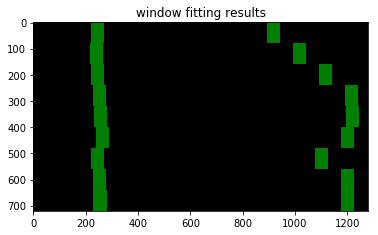

In [27]:
# Read in a thresholded image
warped = binary_warped
# window settings
window_width = 50
window_height = 80  # Break image into 9 vertical layers since image height is 720
margin = 100  # How much to slide left and right for searching


def window_mask(width, height, img_ref, center, level):
    output = np.zeros_like(img_ref)
    output[int(img_ref.shape[0] - (level + 1) * height):int(img_ref.shape[0] - level * height),
           max(0, int(center - width / 2)):min(int(center + width / 2), img_ref.shape[1])] = 1
    return output


def find_window_centroids(image, window_width, window_height, margin):

    # Store the (left,right) window centroid positions per level
    window_centroids = []
    # Create our window template that we will use for convolutions
    window = np.ones(window_width)

    # First find the two starting positions for the left and right lane by using np.sum to get the vertical image slice
    # and then np.convolve the vertical image slice with the window template

    # Sum quarter bottom of image to get slice, could use a different ratio
    l_sum = np.sum(warped[int(3 * warped.shape[0] / 4):,
                          :int(warped.shape[1] / 2)], axis=0)
    l_center = np.argmax(np.convolve(window, l_sum)) - window_width / 2
    r_sum = np.sum(warped[int(3 * warped.shape[0] / 4):,
                          int(warped.shape[1] / 2):], axis=0)
    r_center = np.argmax(np.convolve(window, r_sum)) - \
        window_width / 2 + int(warped.shape[1] / 2)

    # Add what we found for the first layer
    window_centroids.append((l_center, r_center))

    # Go through each layer looking for max pixel locations
    for level in range(1, (int)(warped.shape[0] / window_height)):
        # convolve the window into the vertical slice of the image
        image_layer = np.sum(warped[int(warped.shape[0] - (level + 1) * window_height):int(warped.shape[0] - level * window_height), :], axis=0)
        conv_signal = np.convolve(window, image_layer)
        # Find the best left centroid by using past left center as a reference
        # Use window_width/2 as offset because convolution signal reference is
        # at right side of window, not center of window
        offset = window_width / 2
        l_min_index = int(max(l_center + offset - margin, 0))
        l_max_index = int(min(l_center + offset + margin, warped.shape[1]))
        l_center = np.argmax(
            conv_signal[l_min_index:l_max_index]) + l_min_index - offset
        # Find the best right centroid by using past right center as a
        # reference
        r_min_index = int(max(r_center + offset - margin, 0))
        r_max_index = int(min(r_center + offset + margin, warped.shape[1]))
        r_center = np.argmax(
            conv_signal[r_min_index:r_max_index]) + r_min_index - offset
        # Add what we found for that layer
        window_centroids.append((l_center, r_center))

    return window_centroids


window_centroids = find_window_centroids(
    warped, window_width, window_height, margin)

# If we found any window centers
if len(window_centroids) > 0:

    # Points used to draw all the left and right windows
    l_points = np.zeros_like(warped)
    r_points = np.zeros_like(warped)

    # Go through each level and draw the windows
    for level in range(0, len(window_centroids)):
        # Window_mask is a function to draw window areas
        l_mask = window_mask(window_width, window_height,
                             warped, window_centroids[level][0], level)
        r_mask = window_mask(window_width, window_height,
                             warped, window_centroids[level][1], level)
        # Add graphic points from window mask here to total pixels found
        l_points[(l_points == 255) | ((l_mask == 1))] = 255
        r_points[(r_points == 255) | ((r_mask == 1))] = 255

    # Draw the results
    # add both left and right window pixels together
    template = np.array(r_points + l_points, np.uint8)
    zero_channel = np.zeros_like(template)  # create a zero color channel
    # make window pixels green
    template = np.array(
        cv2.merge((zero_channel, template, zero_channel)), np.uint8)
    # making the original road pixels 3 color channels
    warpage = np.array(cv2.merge((warped, warped, warped)), np.uint8)
    # overlay the orignal road image with window results
    output = cv2.addWeighted(warpage, 1, template, 0.5, 0.0)

# If no window centers found, just display orginal road image
else:
    output = np.array(cv2.merge((warped, warped, warped)), np.uint8)

# Display the final results
plt.imshow(output)
plt.title('window fitting results')
plt.show()

## 12. Measuring curvature
We have so far covered polynomial values for the left and right lane
![curvature](https://d17h27t6h515a5.cloudfront.net/topher/2016/December/58449a23_color-fit-lines/color-fit-lines.jpg)

* Note that the polynomial is a function of $y$
$$ f(y) = A y^2 + B y + C $$
* Because two lanes are vertical in the warped image
* Then we can compute the radius of curvature for every $x = f(y) $ 
$$R_\text{curve} = \frac{\left[ 1 + \left( \frac{dx}{dy} \right)^2 \right]^{\frac{3}{2}}}{\left\lvert \frac{d^2 x}{dy^2} \right\rvert} $$
* And we know
$$ f'(y) = \frac{dx}{dy} = 2 A y + B $$
$$ f''(y) = \frac{d^2 x}{d y^2} = 2 A $$

$$\therefore R_\text{curve} = \frac{\left[1 + (2Ay + B)^2 \right]^{3/2}}{\left\lvert 2A \right\rvert} $$

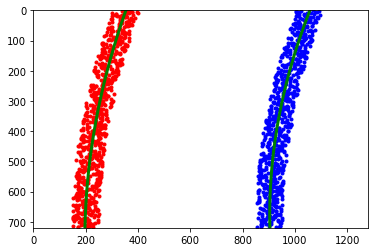

In [28]:
ploty = np.linspace(0, 719, num=720)  # to cover same y-range as image
quadratic_coeff = 3e-4  # arbitrary quadratic coefficient

# For each y position generate random x position within +/-50 pix
# of the line base position in each case (x=200 for left, and x=900 for right)
leftx = np.array([200 + (y**2) * quadratic_coeff + np.random.randint(-50, high=51)
                  for y in ploty])

rightx = np.array([900 + (y**2) * quadratic_coeff + np.random.randint(-50, high=51)
                   for y in ploty])

leftx = leftx[::-1]  # Reverse to match top-to-bottom in y
rightx = rightx[::-1]  # Reverse to match top-to-bottom in y


# Fit a second order polynomial to pixel positions in each fake lane line
left_fit = np.polyfit(ploty, leftx, 2)
left_fitx = left_fit[0] * ploty**2 + left_fit[1] * ploty + left_fit[2]

right_fit = np.polyfit(ploty, rightx, 2)
right_fitx = right_fit[0] * ploty**2 + right_fit[1] * ploty + right_fit[2]

# Plot up the fake data
mark_size = 3
plt.plot(leftx, ploty, 'o', color='red', markersize=mark_size)
plt.plot(rightx, ploty, 'o', color='blue', markersize=mark_size)
plt.xlim(0, 1280)
plt.ylim(0, 720)
plt.plot(left_fitx, ploty, color='green', linewidth=3)
plt.plot(right_fitx, ploty, color='green', linewidth=3)
plt.gca().invert_yaxis()  # to visualize as we do the image

In [29]:
# Define y-value where we want radius of curvature
# I'll choose the maximum y-value, corresponding to the bottom of the image
y_eval = np.max(ploty)
left_curverad = (
    (1 + (2 * left_fit[0] * y_eval + left_fit[1])**2)**1.5) / np.absolute(2 * left_fit[0])

right_curverad = (
    (1 + (2 * right_fit[0] * y_eval + right_fit[1])**2)**1.5) / np.absolute(2 * right_fit[0])

print(left_curverad, right_curverad)

1858.06994885 1493.43515128


In [30]:
# Define conversions in x and y from pixels space to meters
ym_per_pix = 30 / 720  # meters per pixel in y dimension
xm_per_pix = 3.7 / 700  # meters per pixel in x dimension

# Fit new polynomials to x,y in world space
left_fit_cr = np.polyfit(ploty * ym_per_pix, leftx * xm_per_pix, 2)
right_fit_cr = np.polyfit(ploty * ym_per_pix, rightx * xm_per_pix, 2)

# Calculate the new radii of curvature
left_curverad = ((1 + (2 * left_fit_cr[0] * y_eval * ym_per_pix +
                       left_fit_cr[1])**2)**1.5) / np.absolute(2 * left_fit_cr[0])

right_curverad = ((1 + (2 * right_fit_cr[0] * y_eval * ym_per_pix +
                        right_fit_cr[1])**2)**1.5) / np.absolute(2 * right_fit_cr[0])

# Now our radius of curvature is in meters
print(left_curverad, 'm', right_curverad, 'm')
# Example values: 632.1 m    626.2 m

609.779421425 m 489.956229734 m
